<a href="https://colab.research.google.com/github/grasbiel/analise_agua/blob/main/An%C3%A1lise_Rios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Célula 1 - Importações

In [18]:
# CONFIGURAÇÃO E IMPORTAÇÕES

# Instalação de pacotes necessários
!pip install openpyxl -q

# Importações
import pandas as pd
import numpy as np
import re
import folium
from folium.plugins import MarkerCluster, HeatMap
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive

# Configurações de visualização
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
%matplotlib inline

# Conexão com o Google Drive
print("Conectando ao Google Drive...")
try:
    drive.mount('/content/drive')
    print("✅ Drive montado com sucesso.")
except Exception as e:
    print(f"⚠️ Aviso: {e}")

Conectando ao Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive montado com sucesso.


Upload do arquivo

In [19]:
"""
print("Faça o upload do arquivo Excel:")
uploaded=files.upload()

nome_arquivo = next(iter(uploaded))


"""


'\nprint("Faça o upload do arquivo Excel:")\nuploaded=files.upload()\n\nnome_arquivo = next(iter(uploaded))\n\n\n'

Célula 2

In [20]:
# --- CÉLULA 2: FUNÇÕES DE SUPORTE (LIMPEZA) ---

def padronizar_texto(series):
    """
    Padroniza textos: remove acentos, parênteses, espaços extras e converte para maiúsculas.
    """
    series = series.astype(str)
    series = series.str.replace(r"\(.*\)", "", regex=True) # Remove coisas como '(vazão)'
    series = series.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    series = series.str.upper().str.strip()
    # Substitui variações de nulo por NaN real
    series = series.replace(['NAN', 'N.A.', '0', '', 'UNDEFINED'], np.nan)
    return series

def limpar_coordenada_robusta(coord, tipo='lat'):
    """
    Converte coordenadas (DMS ou Decimal), corrige formatação (ex: 02°30)
    e garante o sinal negativo para a região de São Luís.
    """
    if pd.isna(coord): return np.nan

    valor = np.nan

    # 1. Se já for número
    if isinstance(coord, (int, float)):
        valor = float(coord)

    # 2. Se for string (texto)
    elif isinstance(coord, str):
        c = coord.strip().replace(',', '.')
        # Correção para formato misto (ex: 02°305 sem ponto)
        if '°' in c and '.' not in c:
             c = c.replace('°', '.')

        # Limpa tudo que não for número, ponto ou sinal
        c_limpa = re.sub(r'[^0-9\.\-]', '', c)
        try:
            valor = float(c_limpa)
        except ValueError:
            return np.nan

    # 3. Lógica Geográfica (Hemisfério Sul / Oeste)
    # Se o valor for válido mas positivo, inverte o sinal
    if not pd.isna(valor) and valor > 0:
        valor = -valor

    # 4. Filtro de Sanidade (Remove valores impossíveis)
    if tipo == 'lat' and (valor < -90 or valor > 90): return np.nan
    if tipo == 'lon' and (valor < -180 or valor > 180): return np.nan

    return valor

def classificar_conama(valor, parametro):
    """Classifica pH, OD e Turbidez segundo CONAMA 357/2005 (Classe 2)."""
    if pd.isna(valor): return 'Sem Dado'

    padroes = {
        'ph': (6.0, 9.0), # Entre 6 e 9
        'od': (5.0, np.inf), # Maior que 5
        'turbidez': (-np.inf, 100.0) # Menor que 100
    }

    min_val, max_val = padroes.get(parametro, (-np.inf, np.inf))

    if min_val <= valor <= max_val:
        return 'Conforme'
    return 'Não Conforme'

Célula 3

In [26]:
# --- CÉLULA 3: PIPELINE DE DADOS (ETL) ---

# Caminho do arquivo (Verifique se está correto no seu Drive)
caminho_arquivo = "/content/drive/MyDrive/dataset rios/Consolidado.xlsx"

print(f"Lendo arquivo: {caminho_arquivo}...")

try:
    # Carrega os dados brutos
    df_bruto = pd.read_excel(caminho_arquivo)
    print(f"Dados carregados: {df_bruto.shape} registros.")
except FileNotFoundError:
    print("🚨 ERRO: Arquivo não encontrado! Verifique o caminho.")
    raise SystemExit()

# 1. Seleção e Renomeação de Colunas
# Mapeamos os nomes complexos do Excel para nomes simples em Python
mapa_colunas = {
    "Nome Municipio": "municipio",
    "Nome do Corpo D'Água": "rio",
    "Data da Coleta (dd/mm/aaaa)": "data",
    "Hora (hh:mm)": "hora",
    "Posição horizontal da coleta (latitude)": "latitude",
    "Posição vertical da coleta (longitude)": "longitude",
    "Choveu nas ultimas 24 horas (Sim - Não)": "choveu",
    "pH": "ph",
    "Oxigênio dissolvido (mg/L 02)": "od",
    "Turbidez (NTU)": "turbidez"
}

# Filtra apenas as colunas que existem no arquivo
cols_existentes = [c for c in mapa_colunas.keys() if c in df_bruto.columns]
df = df_bruto[cols_existentes].rename(columns=mapa_colunas)

# 2. Padronização de Municípios e Rios
print("Padronizando textos...")
if 'municipio' in df.columns:
    df['municipio'] = padronizar_texto(df['municipio'])
if 'rio' in df.columns:
    df['rio'] = padronizar_texto(df['rio'])

# 3. Filtragem: Apenas São Luís
print("Filtrando município de São Luís...")
df = df[df['municipio'] == 'SAO LUIS'].copy()
print(f"-> Registros em São Luís: {len(df)}")

# 4. Limpeza de Coordenadas
print("Corrigindo coordenadas...")
df['latitude'] = df['latitude'].apply(lambda x: limpar_coordenada_robusta(x, 'lat'))
df['longitude'] = df['longitude'].apply(lambda x: limpar_coordenada_robusta(x, 'lon'))


# --- Módulo de Correção Manual de Inconsistências ---

print("\n--- Verificando Inconsistência do Rio Tibiri ---")

# 1. Identificar o ponto suspeito
# Vamos filtrar quem se chama "Rio Tibiri" mas está muito longe da média dos outros
# (Ajuste os valores de lat/lon se você souber exatamente onde cai o erro,
# mas vou tentar pegar pelo 'outlier')

if 'rio' in df.columns and 'latitude' in df.columns:

    # Pega todos os Tibiris
    tibiris = df[df['rio'].astype(str).str.upper() == 'RIO TIBIRI']

    # Calcula a média de onde o Tibiri deveria estar
    lat_media = tibiris['latitude'].mean()
    lon_media = tibiris['longitude'].mean()

    # Calcula a distância de cada ponto para a média
    # (Distância Euclidiana simples para detecção)
    tibiris['distancia_da_media'] = np.sqrt(
        (tibiris['latitude'] - lat_media)**2 + (tibiris['longitude'] - lon_media)**2
    )

    # Pega os pontos que estão muito longe da média (o erro provavelmente é o maior deles)
    # 0.05 graus é aprox 5km de erro
    suspeitos = tibiris[tibiris['distancia_da_media'] > 0.05]

    if not suspeitos.empty:
        print(f"⚠️ Encontrado(s) {len(suspeitos)} registro(s) do Rio Tibiri fora do padrão espacial:")
        display(suspeitos[['municipio', 'rio', 'latitude', 'longitude', 'data']])

        # AÇÃO: Remover estes índices do DataFrame principal
        indices_para_remover = suspeitos.index
        df = df.drop(indices_para_remover)

        print(f"✅ {len(indices_para_remover)} registro(s) inconsistente(s) removido(s) com sucesso.")
        print(f"Total de registros agora: {len(df)}")
    else:
        print("Nenhum ponto do Rio Tibiri parece estar deslocado drasticamente.")

else:
    print("Colunas necessárias não encontradas para esta verificação.")


# 5. Tratamento de Tipos Numéricos
colunas_num = ['ph', 'od', 'turbidez']
for col in colunas_num:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')



# 6. Criação de Timestamp (Data + Hora)
df['data'] = pd.to_datetime(df['data'], errors='coerce')
# Remove datas inválidas (NaT)
df = df.dropna(subset=['data'])
print("✅ Limpeza inicial concluída.")

Lendo arquivo: /content/drive/MyDrive/dataset rios/Consolidado.xlsx...
Dados carregados: (1366, 39) registros.
Padronizando textos...
Filtrando município de São Luís...
-> Registros em São Luís: 160
Corrigindo coordenadas...

--- Verificando Inconsistência do Rio Tibiri ---
⚠️ Encontrado(s) 1 registro(s) do Rio Tibiri fora do padrão espacial:


,municipio,rio,latitude,longitude,data
490,SAO LUIS,RIO TIBIRI,-2.51859,-44.07091,2023-07-17 00:00:00


✅ 1 registro(s) inconsistente(s) removido(s) com sucesso.
Total de registros agora: 159
✅ Limpeza inicial concluída.


Célula 4

In [22]:
# --- CÉLULA 4: CORREÇÃO ESPACIAL AVANÇADA ---

# 1. Geofencing (Cerca Geográfica)
# Remove pontos que caíram no mar ou em outros municípios por erro de GPS
print("\n1. Aplicando Geofencing (Limites de São Luís)...")
LAT_MIN, LAT_MAX = -2.80, -2.30
LON_MIN, LON_MAX = -44.50, -44.00

df_geo = df[
    (df['latitude'].between(LAT_MIN, LAT_MAX)) &
    (df['longitude'].between(LON_MIN, LON_MAX))
].copy()

removidos = len(df) - len(df_geo)
print(f"-> {removidos} pontos removidos por estarem fora dos limites geográficos.")

# 2. Machine Learning (KNN) para corrigir nomes de rios
print("\n2. Executando Classificação de Rios (KNN)...")

# Dados válidos para treino (tem lat, lon e nome de rio)
df_treino = df_geo.dropna(subset=['latitude', 'longitude', 'rio']).copy()

if not df_treino.empty:
    X = df_treino[['latitude', 'longitude']].values
    y = df_treino['rio'].values

    # Treina o modelo com o vizinho mais próximo
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X, y)

    # Aplica o modelo em TODOS os dados válidos (para corrigir nomes errados e preencher vazios)
    # Usamos .copy() para evitar o Warning
    df_predicao = df_geo.dropna(subset=['latitude', 'longitude']).copy()

    # Prediz o nome correto baseado na localização
    rios_corrigidos = knn.predict(df_predicao[['latitude', 'longitude']].values)

    # Salva o original para comparação e atualiza o oficial
    df_geo.loc[df_predicao.index, 'rio_original'] = df_geo.loc[df_predicao.index, 'rio']
    df_geo.loc[df_predicao.index, 'rio'] = rios_corrigidos

    print("-> Nomes de rios padronizados via Machine Learning.")
else:
    print("⚠️ Dados insuficientes para treinar o modelo KNN.")

# Atualiza o DataFrame principal
df_final = df_geo.copy()
print(f"✅ Base final pronta com {len(df_final)} registros.")


1. Aplicando Geofencing (Limites de São Luís)...
-> 23 pontos removidos por estarem fora dos limites geográficos.

2. Executando Classificação de Rios (KNN)...
-> Nomes de rios padronizados via Machine Learning.
✅ Base final pronta com 136 registros.


In [23]:
# ANÁLISE DE QUALIDADE DA ÁGUA

print("Classificando parâmetros segundo CONAMA 357...")

# Aplica a classificação
df_final['status_ph'] = df_final['ph'].apply(lambda x: classificar_conama(x, 'ph'))
df_final['status_od'] = df_final['od'].apply(lambda x: classificar_conama(x, 'od'))
df_final['status_turbidez'] = df_final['turbidez'].apply(lambda x: classificar_conama(x, 'turbidez'))

# Cria índice de problemas (0 = Bom, 3 = Péssimo)
# Soma 1 para cada parâmetro "Não Conforme"
df_final['indice_problemas'] = (
    (df_final['status_ph'] == 'Não Conforme').astype(int) +
    (df_final['status_od'] == 'Não Conforme').astype(int) +
    (df_final['status_turbidez'] == 'Não Conforme').astype(int)
)

# Relatório Rápido
print("\n--- RESUMO DA QUALIDADE ---")
print(df_final['indice_problemas'].value_counts().sort_index().rename("Qtd Amostras por Nº de Problemas"))

# Salvar arquivo final processado
arquivo_saida = "/content/drive/MyDrive/Dados_Processados_SaoLuis.xlsx"
df_final.to_excel(arquivo_saida, index=False)
print(f"\n💾 Arquivo processado salvo em: {arquivo_saida}")

Classificando parâmetros segundo CONAMA 357...

--- RESUMO DA QUALIDADE ---
indice_problemas
0    63
1    52
2    20
3     1
Name: Qtd Amostras por Nº de Problemas, dtype: int64

💾 Arquivo processado salvo em: /content/drive/MyDrive/Dados_Processados_SaoLuis.xlsx


Mapas e Visualizações

Gerando Mapa de Conformidade...


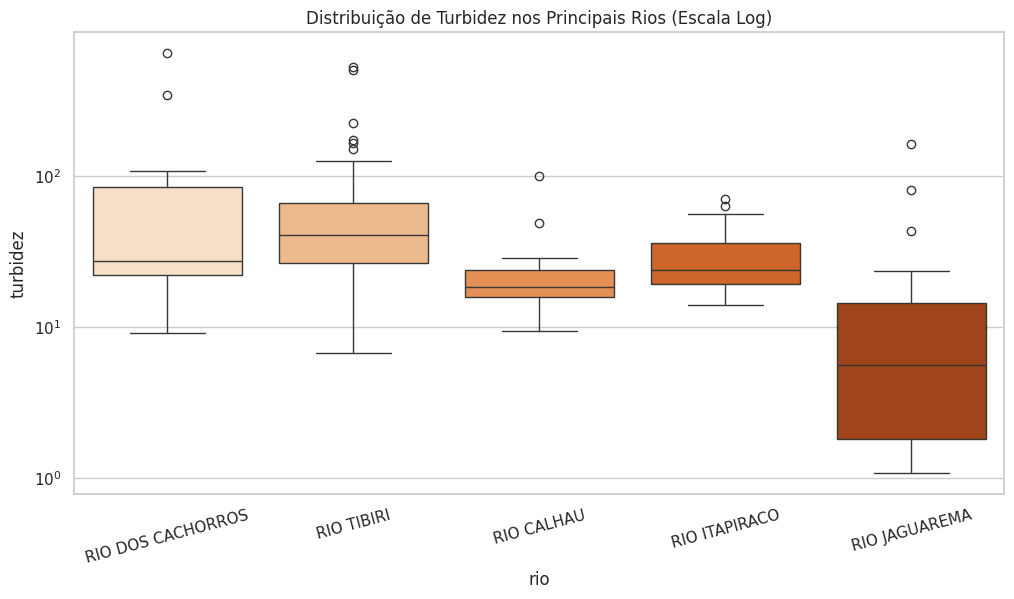

In [24]:
# --- CÉLULA 6: VISUALIZAÇÃO ---

# 1. Mapa Interativo de Conformidade
print("Gerando Mapa de Conformidade...")

# Remove sem lat/lon apenas para o mapa
df_mapa = df_final.dropna(subset=['latitude', 'longitude'])
centro = [df_mapa['latitude'].mean(), df_mapa['longitude'].mean()]

m = folium.Map(location=centro, zoom_start=11, tiles='CartoDB positron')
marker_cluster = MarkerCluster().add_to(m)

# Função de cor
def cor_status(n_problemas):
    if n_problemas == 0: return 'green'
    if n_problemas == 1: return 'orange'
    return 'red'

for _, row in df_mapa.iterrows():
    cor = cor_status(row['indice_problemas'])

    html = f"""
    <b>Rio:</b> {row['rio']}<br>
    <b>Data:</b> {row['data'].strftime('%d/%m/%Y')}<br>
    <hr>
    <b>Problemas:</b> {row['indice_problemas']}<br>
    pH: {row['ph']} ({row['status_ph']})<br>
    Turbidez: {row['turbidez']} ({row['status_turbidez']})
    """

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(html, max_width=250),
        icon=folium.Icon(color=cor, icon='info-sign')
    ).add_to(marker_cluster)

# Legenda
legenda = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index:9999; background:white; padding:10px; border:2px solid grey;">
<b>Legenda (Qualidade):</b><br>
<i class="fa fa-circle" style="color:green"></i> Conforme (0 problemas)<br>
<i class="fa fa-circle" style="color:orange"></i> Atenção (1 problema)<br>
<i class="fa fa-circle" style="color:red"></i> Crítico (2+ problemas)
</div>
'''
m.get_root().html.add_child(folium.Element(legenda))

display(m)

# 2. Gráfico Estatístico (Boxplot)
plt.figure(figsize=(12, 6))
top_rios = df_final['rio'].value_counts().head(5).index
df_plot = df_final[df_final['rio'].isin(top_rios)]

sns.boxplot(data=df_plot, x='rio', y='turbidez', palette='Oranges')
plt.yscale('log') # Escala Log para ver melhor
plt.title("Distribuição de Turbidez nos Principais Rios (Escala Log)")
plt.xticks(rotation=15)
plt.show()

Gerando gráficos de conformidade CONAMA...


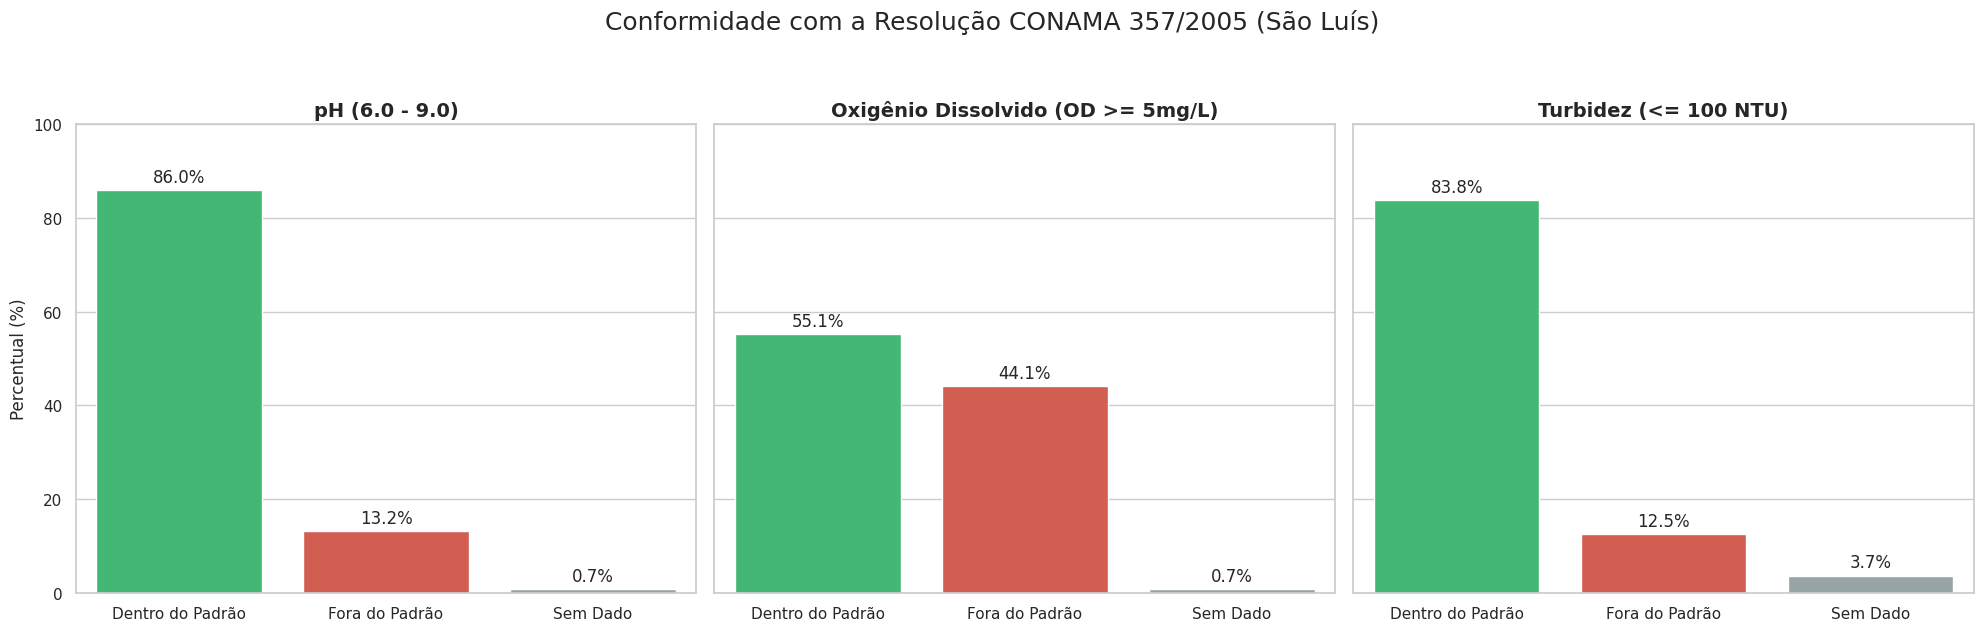

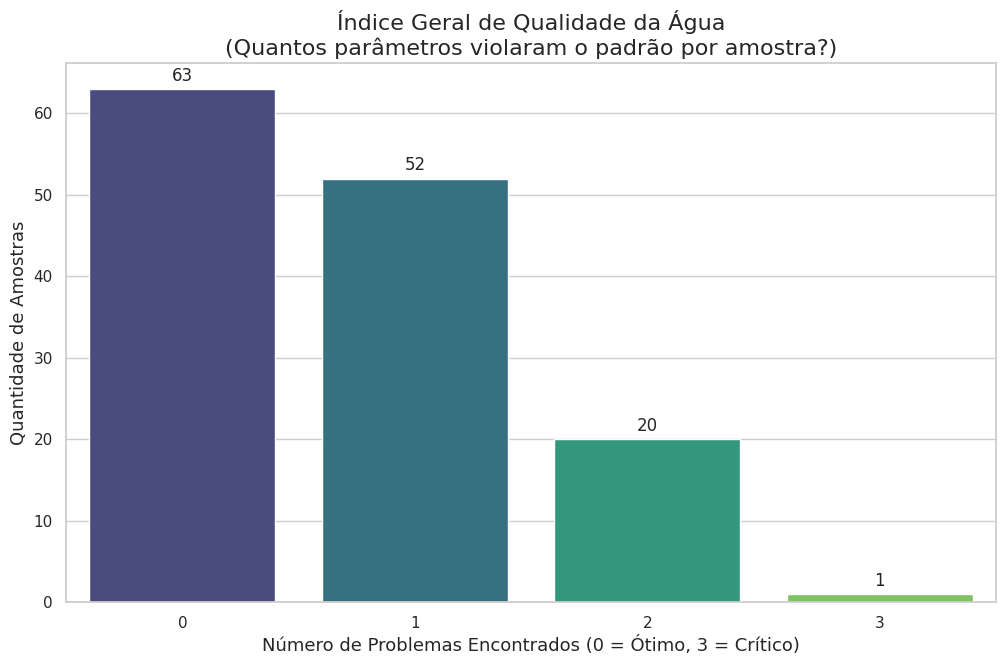

In [25]:
# VISUALIZAÇÃO DOS ÍNDICES CONAMA ---

print("Gerando gráficos de conformidade CONAMA...")

# Configuração do estilo
sns.set_theme(style="whitegrid")
cores_conama = {'Dentro do Padrão': '#2ecc71', 'Fora do Padrão': '#e74c3c', 'Sem Dado': '#95a5a6'}

# 1. Gráfico de Barras Comparativo (Percentual por Parâmetro)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Conformidade com a Resolução CONAMA 357/2005 (São Luís)', fontsize=18, y=1.05)

def plotar_barra_percentual(ax, coluna, titulo):
    if coluna in df_final.columns:
        # Calcula percentuais
        counts = df_final[coluna].value_counts(normalize=True).mul(100).reset_index()
        counts.columns = ['Status', 'Percentual']

        # Plota
        sns.barplot(x='Status', y='Percentual', data=counts, ax=ax, palette=cores_conama, order=['Dentro do Padrão', 'Fora do Padrão', 'Sem Dado'])

        # Estilização
        ax.set_title(titulo, fontsize=14, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Percentual (%)' if ax == axes[0] else '')
        ax.set_ylim(0, 100)

        # Adiciona rótulos nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', fontsize=12, padding=3)

# Gera os 3 subgráficos
# Recalcula os status caso não estejam na memória (garantia)
def classificar(val, padrao):
    if pd.isna(val): return 'Sem Dado'
    min_v, max_v = padrao
    return 'Dentro do Padrão' if min_v <= val <= max_v else 'Fora do Padrão'

df_final['status_ph_graf'] = df_final['ph'].apply(lambda x: classificar(x, (6.0, 9.0)))
df_final['status_od_graf'] = df_final['od'].apply(lambda x: classificar(x, (5.0, np.inf)))
df_final['status_turb_graf'] = df_final['turbidez'].apply(lambda x: classificar(x, (-np.inf, 100.0)))

plotar_barra_percentual(axes[0], 'status_ph_graf', 'pH (6.0 - 9.0)')
plotar_barra_percentual(axes[1], 'status_od_graf', 'Oxigênio Dissolvido (OD >= 5mg/L)')
plotar_barra_percentual(axes[2], 'status_turb_graf', 'Turbidez (<= 100 NTU)')

plt.tight_layout()
plt.show()

# 2. Gráfico do Índice Geral de Problemas (Countplot)
plt.figure(figsize=(12, 7))
ax = sns.countplot(
    x='indice_problemas',
    data=df_final,
    palette='viridis'
)

plt.title('Índice Geral de Qualidade da Água\n(Quantos parâmetros violaram o padrão por amostra?)', fontsize=16)
plt.xlabel('Número de Problemas Encontrados (0 = Ótimo, 3 = Crítico)', fontsize=13)
plt.ylabel('Quantidade de Amostras', fontsize=13)

# Adiciona os números acima das barras
for container in ax.containers:
    ax.bar_label(container, fontsize=12, padding=3)

plt.show()